In [16]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import QuantumCircuit, execute, Aer
from qiskit import BasicAer
from sklearn.decomposition import PCA

import time
import warnings
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 42

import numpy as np
import pickle
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt
import pandas as pd

algorithm_globals.random_seed = 42

In [23]:
import tensorflow as tf

# Data Processing tools
import numpy as np
from sklearn.model_selection import train_test_split 

# QML tools
import cirq
import sympy

# Visualization Tools
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt

In [43]:
data_path='data'
#load the actual hackthon data (fashion-mnist)
images=np.load(data_path+'/images.npy')
labels=np.load(data_path+'/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
#plt.imshow(images[1])


images = images.reshape(images.shape[0], *(28,28,1))

# Downscaling the images
images = tf.image.resize(images, (2,2)).numpy()


X_train, X_test, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

X_test, X_valid, test_labels, valid_labels = train_test_split(
    images, labels, test_size=0.5
)



# FLattening the images
X_train = X_train.reshape(X_train.shape[0], *(1,4,1))
X_valid = X_valid.reshape(X_valid.shape[0], *(1,4,1))
X_test = X_test.reshape(X_test.shape[0], *(1,4,1))
     



def binary_encode(X,threshold=0.5):
    encoded_images = list()
    for image in X:
    # pixel value is 1 if it's greater than threshold or else zero
        encoded_image = [1 if j>threshold else 0 for j in image[0]]
        encoded_images.append(encoded_image)
    return np.array(encoded_images)

X_train = binary_encode(X_train)
      
def create_circuit_from_image(encoded_image):
    qubits = cirq.GridQubit.rect(2,2)
    circuit = cirq.Circuit()
    for i, pixel in enumerate(encoded_image):
        if pixel:
            circuit.append(cirq.X(qubits[i]))
    return circuit

X_train = [create_circuit_from_image(encoded_image) for encoded_image in X_train]

In [ ]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

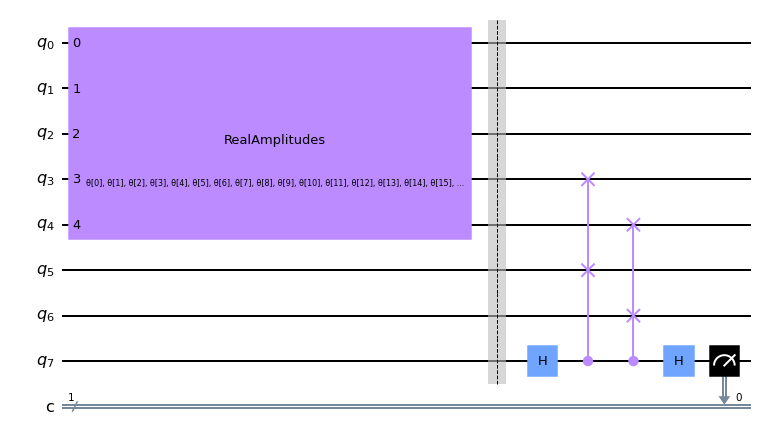

In [6]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit


num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl")

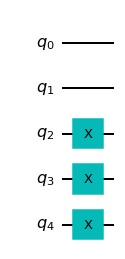

In [7]:
def domain_wall(circuit, a, b):
    # Here we place the Domain Wall to qubits a - b in our circuit
    for i in np.arange(int(b / 2), int(b)):
        circuit.x(i)
    return circuit


domain_wall_circuit = domain_wall(QuantumCircuit(5), 0, 5)
domain_wall_circuit.draw("mpl")

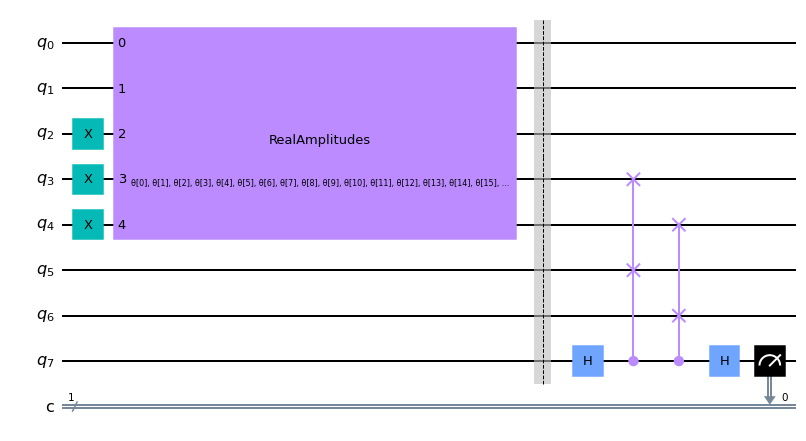

In [8]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw("mpl")

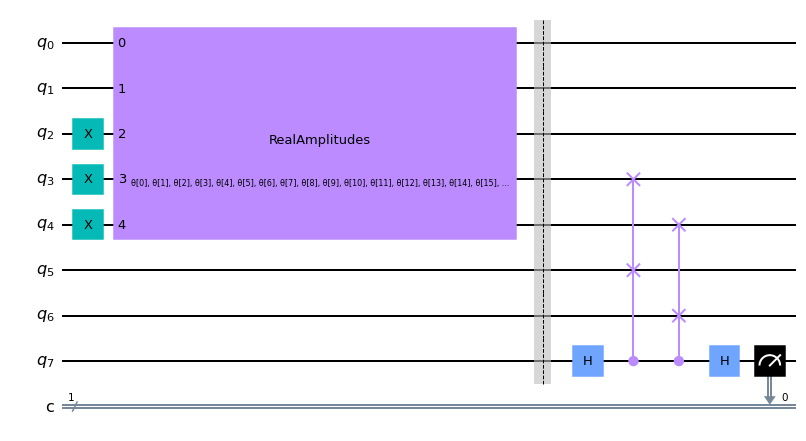

In [9]:
ae = auto_encoder_circuit(num_latent, num_trash)
qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(domain_wall_circuit, range(num_latent + num_trash))
qc = qc.compose(ae)
qc.draw("mpl")

In [10]:
def cost_func_domain(params_values):
    probabilities = qnn.forward([], params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

In [12]:
# Here we define our interpret for our SamplerQNN
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=[],
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

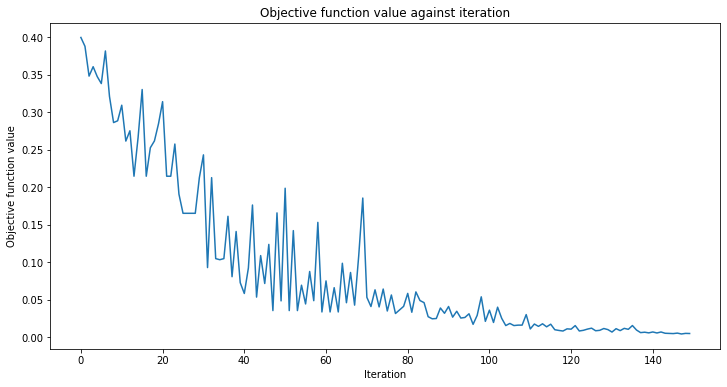

Fit in 17.66 seconds


In [13]:
opt = COBYLA(maxiter=150)
initial_point = algorithm_globals.random.random(ae.num_parameters)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(cost_func_domain, initial_point)
elapsed = time.time() - start

print(f"Fit in {elapsed:0.2f} seconds")

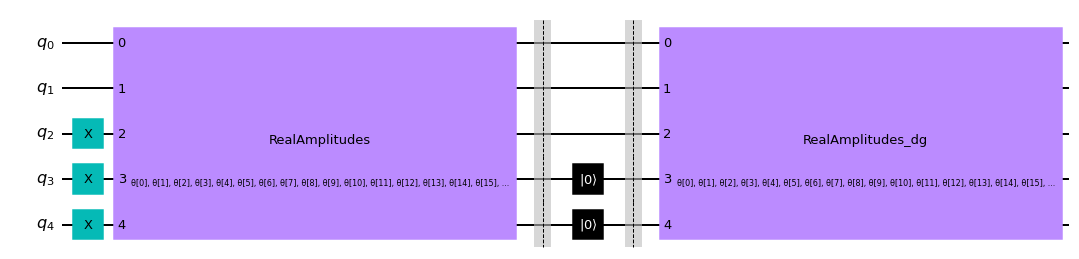

In [14]:
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(domain_wall_circuit)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

test_qc.draw("mpl")

In [15]:
test_qc = test_qc.assign_parameters(opt_result.x)

In [16]:
domain_wall_state = Statevector(domain_wall_circuit).data
output_state = Statevector(test_qc).data

fidelity = np.sqrt(np.dot(domain_wall_state.conj(), output_state) ** 2)
print("Fidelity of our Output State with our Input State: ", fidelity.real)

Fidelity of our Output State with our Input State:  0.995381367885512


In [36]:
# Do data padding here
padded_images = np.array([np.pad(image,(2,),'minimum') for image in images])
padded_images.shape

(2000, 32, 32)

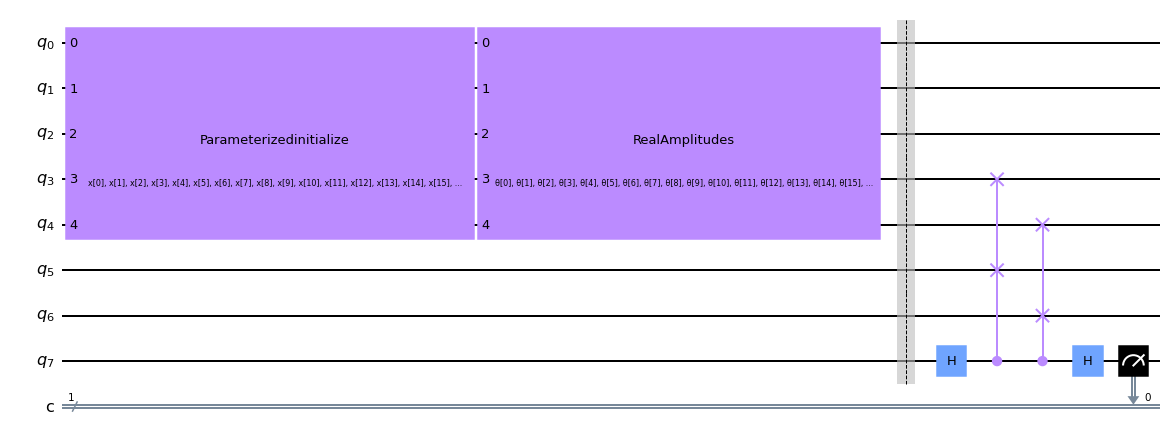

In [ ]:
num_latent = 3
num_trash = 2

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw("mpl")

In [ ]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=2,
)

In [ ]:
def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

In [ ]:
with open("12_qae_initial_point.json", "r") as f:
    initial_point = json.load(f)

In [ ]:
opt = COBYLA(maxiter=150)

objective_func_vals = []
# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


NameError: name 'train_images' is not defined

In [ ]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(4)
test_qc.reset(3)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())

# sample new images
test_images, test_labels = get_dataset_digits(2, draw=False)
for image, label in zip(test_images, test_labels):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, (8, 4))

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, (8, 4))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(original_sv)
    ax1.set_title("Input Data")
    ax2.imshow(output_sv)
    ax2.set_title("Output Data")
    plt.show()